In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

from tqdm import tqdm

import ef_tools

Using TensorFlow backend.


In [2]:
import importlib
importlib.reload(ef_tools)
################################################################################

# load data
if os.path.exists("X.npy"):
    X = np.load("X.npy", allow_pickle=True)
    y = np.load("y.npy", allow_pickle=True)
else:
    X, y = ef_tools.open_file("/home/callum/Documents/bbb/user.jagrundy.20736236._000001.MiniNTuple.root")
    np.save("X.npy", X, allow_pickle=True)
    np.save("y.npy", y, allow_pickle=True)

# load data
#X, y = qg_jets.load(train + val + test)

# convert labels to categorical
Y=y
#Y = to_categorical(y, num_classes=2)

print('Loaded jets')

Loaded jets


In [3]:
# preprocess by centering jets and normalizing pts
for x in tqdm(X):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

100%|██████████| 435653/435653 [00:38<00:00, 11209.06it/s]Finished preprocessing



In [4]:
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 0.7, 0.2, 0.1
# train, val, test = 1000000, 200000, 200000

# network architecture parameters
Phi_sizes, F_sizes = (700, 500, 300, 100), (700, 500, 400, 100)

# network training parameters
num_epoch = 10
batch_size = 500

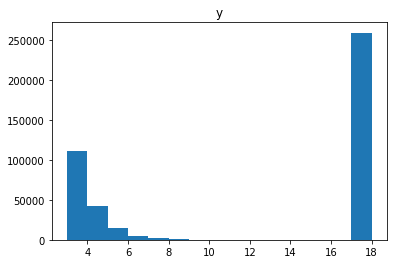

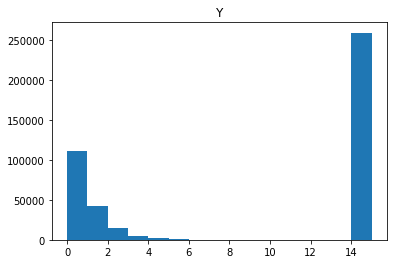

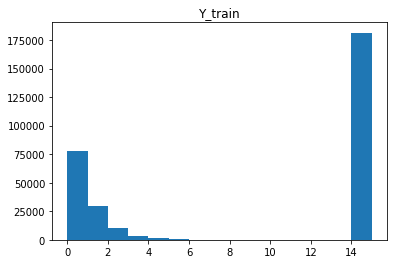

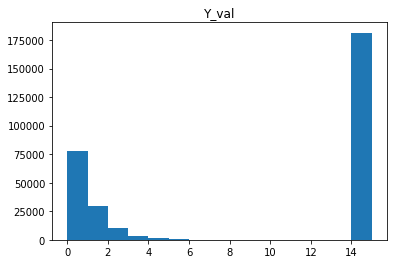

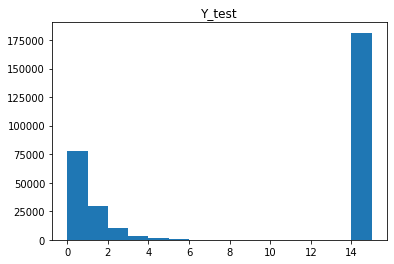

Done train/val/test split
Model summary:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 700)    3500        input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 700)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 500)    350500      activation_1[0][0]               
___________________________________________________

In [5]:
input_dim =X.shape[2]  # parameters per jet

Y = y[:,3:]  # chop off first 3 jets which are always 1

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

plt.title("y")
plt.hist(y.argmax(axis=1), bins=15)
plt.show()
plt.title("Y")
plt.hist(Y.argmax(axis=1), bins=15)
plt.show()
plt.title("Y_train")
plt.hist(Y_train.argmax(axis=1), bins=15)
plt.show()
plt.title("Y_val")
plt.hist(Y_train.argmax(axis=1), bins=15)
plt.show()
plt.title("Y_test")
plt.hist(Y_train.argmax(axis=1), bins=15)
plt.show()

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=input_dim, output_dim=Y.shape[1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, Phi_l2_regs=0.0, F_l2_regs=0.0)

In [6]:
# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

Train on 304958 samples, validate on 87130 samples
Epoch 1/50
304958/304958 [==============================] - 110s 361us/step - loss: 133.7008 - acc: 0.5913 - val_loss: 30.2241 - val_acc: 0.5938
Epoch 2/50
304958/304958 [==============================] - 114s 373us/step - loss: 13.9981 - acc: 0.5964 - val_loss: 4.9021 - val_acc: 0.5938
Epoch 3/50
304958/304958 [==============================] - 110s 360us/step - loss: 2.5229 - acc: 0.5964 - val_loss: 1.3814 - val_acc: 0.5938
Epoch 4/50
304958/304958 [==============================] - 106s 346us/step - loss: 1.1885 - acc: 0.5964 - val_loss: 1.1158 - val_acc: 0.5938
Epoch 5/50
304958/304958 [==============================] - 105s 345us/step - loss: 1.1058 - acc: 0.5964 - val_loss: 1.1030 - val_acc: 0.5938
Epoch 6/50
304958/304958 [==============================] - 105s 344us/step - loss: 1.1000 - acc: 0.5964 - val_loss: 1.0997 - val_acc: 0.5938
Epoch 7/50
304958/304958 [==============================] - 105s 344us/step - loss: 1.0973 - 

KeyboardInterrupt: 

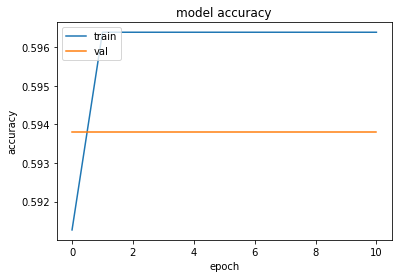

In [7]:
plt.plot(pfn.model.history.history['acc'])
plt.plot(pfn.model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:

# get predictions on test data
preds = pfn.predict(X_test)


43565
[2.5237265e-01 9.6616238e-02 3.4470234e-02 1.2666000e-02 4.3168869e-03
 1.5721689e-03 7.3977048e-04 1.0767734e-03 1.5093806e-03 2.1446038e-04
 1.3462230e-04 2.2594626e-04 2.1403253e-03 1.6851202e-04 2.6746746e-04
 5.9150863e-01]
18


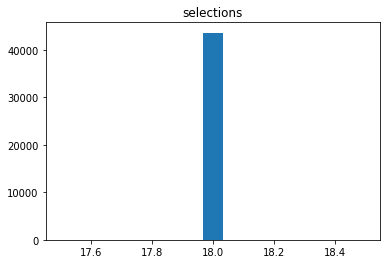

[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


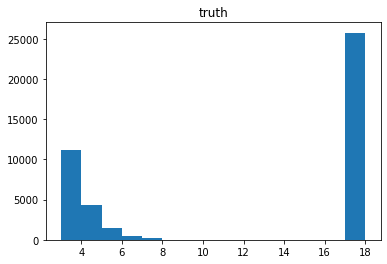

100%|██████████| 4356/4356 [00:00<00:00, 65133.45it/s]


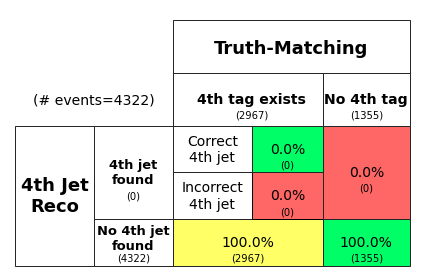

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
print(len(X_test))
preds_max = np.argmax(preds, axis=1) + 3
print(preds[0])
print(preds_max[0])

plt.title("selections")
plt.hist(preds_max, bins=15)
plt.show()

preds_arr = np.zeros((len(preds_max), len(preds[0])+3))
for i, p in enumerate(preds_max):
    preds_arr[i][p] = 1

# chop off 'no jet' jet
preds_arr = preds_arr[:,:-1]

ones = np.ones((len(Y_test), 3))
truth = np.concatenate((ones, Y_test), axis=1)[:,:-1]
print(truth[0])

tag = X_test[:,:,3]

plt.title("truth")
plt.hist(Y_test.argmax(axis=1)+3, bins=15)
plt.show()

(truth_train, truth_val, truth_test, 
 tag_train, tag_val, tag_test) = data_split(truth, tag, val=val, test=test)

import sys
import os
sys.path.append(os.path.realpath(".."))
import tools
import importlib
importlib.reload(tools)

truth_test = truth_test.astype(int)
tag_test = tag_test.astype(int)
preds_arr = preds_arr.astype(int)

tools.evaluate_model(truth_test, tag_test, preds_arr)